<a href="https://colab.research.google.com/github/Davidportlouis/flower_recognition/blob/master/flower_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torchvision import datasets,transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from helper import plot_batch,train,test,predict,predict_image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/gdrive/My Drive/kaggle"
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip
!mkdir test
!mv ./flowers/flowers/* ./test/
!rmdir ./flowers/flowers/
!mkdir train
mv flowers/* ./train/
!rm -rf ./train/.ipynb_checkpoints

In [3]:
train_transform = transforms.Compose([
  transforms.RandomResizedCrop(255),
  transforms.RandomRotation(45),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
  transforms.RandomResizedCrop(255),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder("train",transform=train_transform)
test_data = datasets.ImageFolder("test",transform=test_transform)

train_len = len(train_data)
idx = list(range(train_len))
np.random.shuffle(idx)
split = int(np.floor(0.2 * train_len))
valid_idx,train_idx = idx[:split],idx[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data,batch_size=20,sampler=train_sampler)
valid_loader = DataLoader(train_data,batch_size=20,sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=20,shuffle=True)
classes = train_data.classes

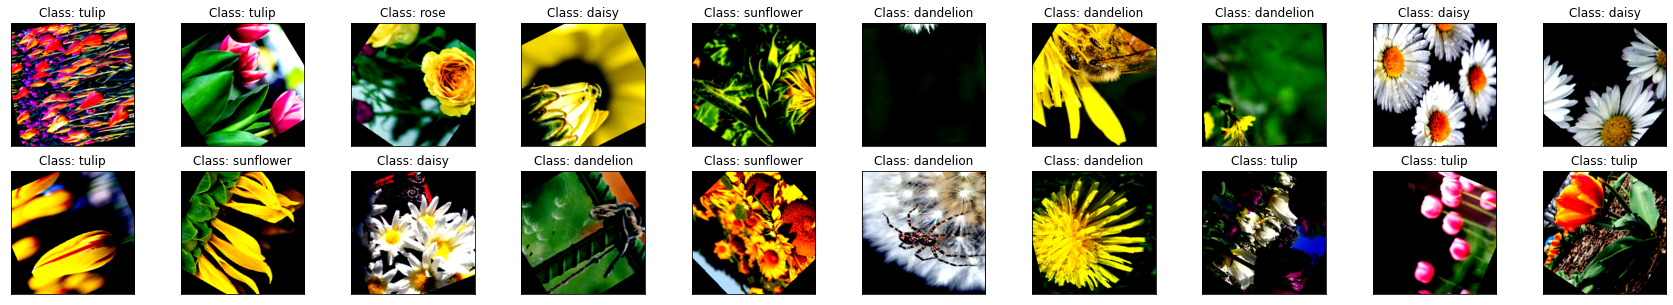

In [4]:
train_images,train_labels = next(iter(train_loader))
plot_batch(train_images,classes,train_labels,normalize=True)

In [11]:
class FloraNet(nn.Module):
  def __init__(self,conv_dim=32):
    super(FloraNet,self).__init__()
    self.conv_1 = nn.Conv2d(3,conv_dim,3,1,1)
    self.conv_2 = nn.Conv2d(conv_dim,conv_dim*2,3,1,1)
    self.conv_3 = nn.Conv2d(conv_dim*2,conv_dim*4,3,1,1)
    self.maxpool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.3)
    self.bnorm_1 = nn.BatchNorm2d(conv_dim)
    self.bnorm_2 = nn.BatchNorm2d(conv_dim*2)
    self.bnorm_3 = nn.BatchNorm2d(conv_dim*4)
    self.fc1 = nn.Linear(31*31*conv_dim*4,2048)
    self.fc2 = nn.Linear(2048,512)
    self.out = nn.Linear(512,5)
    
  def forward(self,x):
    x = self.conv_1(x)
    x = F.relu(self.bnorm_1(x))
    x = self.maxpool(x)
    x = self.conv_2(x)
    x = F.relu(self.bnorm_2(x))
    x = self.maxpool(x)
    x = self.conv_3(x)
    x = F.relu(self.bnorm_3(x))
    x = self.maxpool(x)
    x = self.dropout(x)
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.out(x)
    return x

model = FloraNet()
model = model.to(device)
print(model)

FloraNet(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (bnorm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=123008, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=5, bias=True)
)


In [12]:
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [13]:
train_loss,valid_loss = train(model,train_loader,valid_loader,optimizer,criterion,10,device)

epoch: 1/10 trainloss: 1.37062 validloss: 1.20107 time: 73.651 sec
Loss decresed: inf -> 1.20107
epoch: 2/10 trainloss: 1.24864 validloss: 1.19405 time: 74.496 sec
Loss decresed: 1.20107 -> 1.19405
epoch: 3/10 trainloss: 1.19795 validloss: 1.12498 time: 74.030 sec
Loss decresed: 1.19405 -> 1.12498
epoch: 4/10 trainloss: 1.15420 validloss: 1.10954 time: 74.716 sec
Loss decresed: 1.12498 -> 1.10954
epoch: 5/10 trainloss: 1.11831 validloss: 1.11535 time: 73.614 sec
epoch: 6/10 trainloss: 1.10092 validloss: 1.04613 time: 74.734 sec
Loss decresed: 1.10954 -> 1.04613
epoch: 7/10 trainloss: 1.09145 validloss: 1.00666 time: 74.137 sec
Loss decresed: 1.04613 -> 1.00666
epoch: 8/10 trainloss: 1.08589 validloss: 1.01023 time: 74.828 sec
epoch: 9/10 trainloss: 1.06203 validloss: 0.99889 time: 74.075 sec
Loss decresed: 1.00666 -> 0.99889
epoch: 10/10 trainloss: 1.02060 validloss: 1.02962 time: 75.237 sec


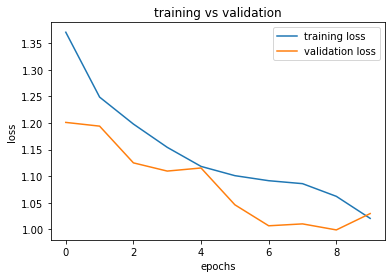

In [14]:
plt.plot(train_loss,label="training loss")
plt.plot(valid_loss,label="validation loss")
plt.title("training vs validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [15]:
model.load_state_dict(torch.load("model_weights.pth"))

<All keys matched successfully>

In [16]:
test(model,test_loader,optimizer,criterion,device)

testloss: 0.968884 accuracy: 0.593


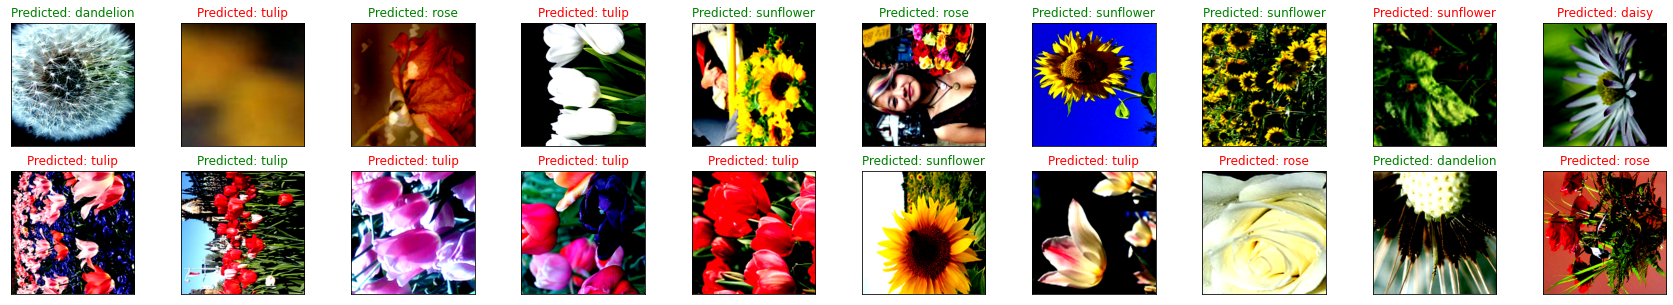

In [17]:
test_images,test_labels = next(iter(test_loader))
predict(test_images,classes,test_labels,model,device)